# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import json
import numpy as np
import time

import imutils
from PIL import Image, ImageDraw

# Root directory of the project
ROOT_DIR = os.path.abspath("/home/vlados/Documents/Mask_RCNN")

# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs", 
                         "humpback_tails20181222T2153", "humpback_tails20181223T0122")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(MODEL_DIR, "mask_rcnn_humpback_tails_0010.h5")
# Download COCO trained weights from Releases if needed
#if not os.path.exists(COCO_MODEL_PATH):
#    utils.download_trained_weights(COCO_MODEL_PATH)

/home/vlados/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Configurations

In [2]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "Humpback_tails"

    # Train on 1 GPU and 8 images per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 500

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000
    
config = ShapesConfig()
#config.display()

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

In [5]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('/home/vlados/Documents/Mask_RCNN/generated/val/coco_annotations.json', 
                        '/home/vlados/Documents/Mask_RCNN/generated/val/images')
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data('/home/vlados/Documents/Mask_RCNN/generated/train/coco_annotations.json', 
                      '/home/vlados/Documents/Mask_RCNN/generated/train/images')
dataset_val.prepare()

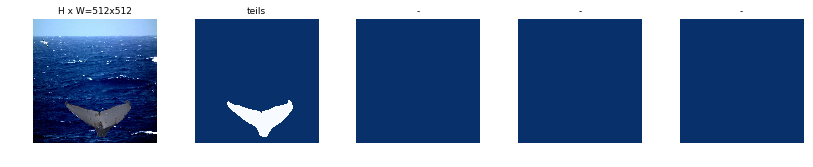

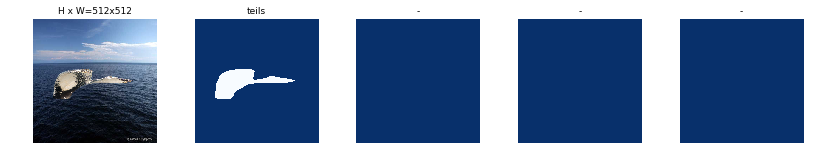

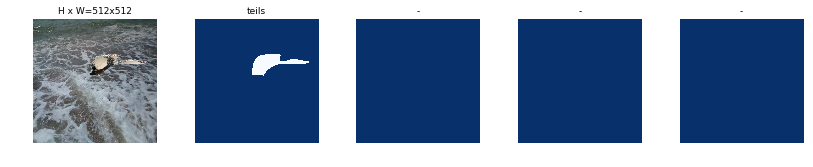

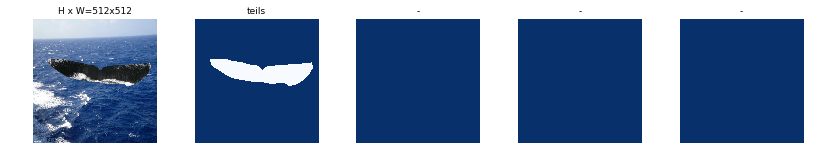

In [10]:
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

## Create Model

In [24]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [9]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

Re-starting from epoch 10


## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [23]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=5, 
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')

NameError: name 'model' is not defined

In [10]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [3]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.85

inference_config = InferenceConfig()

In [4]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

In [5]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
#model_path = model.find_last()
model_path = COCO_MODEL_PATH
# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/vlados/Documents/Mask_RCNN/logs/humpback_tails20181222T2153/humpback_tails20181223T0122/mask_rcnn_humpback_tails_0010.h5
Re-starting from epoch 10


In [2]:
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

In [72]:
train_dir = '/media/vlados/FreeSpace/Kaggle/Humpback/Transform'
train_file = os.listdir(train_dir)
dataset_file = os.listdir('/media/vlados/FreeSpace/Kaggle/Humpback/Test')

result=list(set(train_file) ^ set(dataset_file))
len(result)

145

In [73]:
train_dir = '/media/vlados/FreeSpace/Kaggle/Humpback/Test'
new_dataset_dir = '/media/vlados/FreeSpace/Kaggle/Humpback'

image_paths = []
#files_names = sorted(os.listdir(train_dir))
files_names = result

for filename in files_names:
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(train_dir, filename))

output_dir = os.path.join(new_dataset_dir, 'new_dataset_2')

# try:
#     os.mkdir(output_dir)
# except OSError as exc:
#     if exc.Errno != errno.EEXIST:
#         raise
#     pass

for i, image_path in enumerate(image_paths):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (500, 300))
    results = model.detect([img], verbose=0)
    r = results[0]
    
    if r['rois'].shape == (0,4):
        continue
    
    out_img = create_mask(img, r['rois'], r['masks'])
   #   out_img = cv2.resize(out_img, (512, 512))
    
#     cv2.imwrite(os.path.join(output_dir, files_names[i]), out_img)
    out_img = cv2.copyMakeBorder(out_img, top=10, bottom=10, left=10, right=10, 
                                 borderType=cv2.BORDER_CONSTANT, value=[0,0,0])
    cv2.imwrite(os.path.join('/media/vlados/FreeSpace/Kaggle/Humpback/Transform', files_names[i]), out_img)
    
    print(image_path)

/media/vlados/FreeSpace/Kaggle/Humpback/Test/15cc22b7e.png
/media/vlados/FreeSpace/Kaggle/Humpback/Test/458bb4815.png


In [18]:
train_dir = '/media/vlados/FreeSpace/Kaggle/Humpback/Transform'
output_dir = os.path.join(new_dataset_dir, 'new_dataset_2')
train_list = os.listdir(output_dir)

for i in train_list:
    os.remove(output_dir + '/{}'.format(i))

## Evaluation

In [32]:
def create_mask(image, rois, mask):    
    
    m = mask[:, :]
    m = np.sum(m * np.arange(1, m.shape[-1] + 1), -1, dtype=np.uint8)
    mask_inv = m[r['rois'][0][0]:r['rois'][0][2], r['rois'][0][1]:r['rois'][0][3]]
    img = image[r['rois'][0][0]:r['rois'][0][2], r['rois'][0][1]:r['rois'][0][3]]

    out_img = cv2.bitwise_and(img, img, mask=mask_inv)
    
    out_img = imutils.resize(out_img, width=364)
    
    if out_img.shape[0] > 364:
        out_img = cv2.resize(out_img, (364,364))
    
    up_hight = (384-out_img.shape[0])//2
    down_hight = 384 - up_hight - out_img.shape[0]
    
    new_img = np.zeros((up_hight, 364, 3))
        
    new_img = np.append(new_img, out_img, axis=0)
    new_img = np.append(new_img, np.zeros((down_hight, 364, 3)), axis=0)
    
    return new_img

In [10]:
dataset_file = os.listdir('/media/vlados/FreeSpace/Kaggle/Humpback/new_dataset_2')

for i in tqdm(dataset_file):
    img = cv2.imread(os.path.join('/media/vlados/FreeSpace/Kaggle/Humpback/new_dataset_2', i))
    img = cv2.resize(img, (364, 364))
    img = cv2.copyMakeBorder(img, top=10, bottom=10, left=10, right=10, 
                                 borderType=cv2.BORDER_CONSTANT, value=[0,0,0])
    cv2.imwrite(os.path.join('/media/vlados/FreeSpace/Kaggle/Humpback/new_dataset_2', i), img)

100%|██████████| 24750/24750 [51:13<00:00, 11.27it/s]  
